In [ ]:
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from skimage import filters

In [ ]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def create_elliptical_mask(h, w, center=None, radius=None, a=None, b=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt( ((X - center[0])**2)/(a**2) + ((Y-center[1])**2)/(b**2) )

    mask = dist_from_center <= radius
    return mask

In [ ]:
filename = 'quad_scan_east_slow_ions_2023_2GeV_2023_09_05_14h37m04s'
with open(filename+"/"+filename+".p", 'rb') as f:
    data = pickle.load(f)

In [ ]:
timestamp_list = data[0]
btv_dict = data[1]
btv_image_dict = data[2]
converter_dict = data[3]
logical_k_dict = data[4]
intensity_list = data[5]

# Filter some shots that were bad using the simple method of computing the beam size

In [ ]:
for index_to_remove in reversed([0]): # To prevent index shifting
    timestamp_list.pop(index_to_remove)
    for key in btv_dict:
        btv_dict[key].pop(index_to_remove)
    for key in btv_image_dict:
        btv_image_dict[key].pop(index_to_remove)
    for key in converter_dict:
        converter_dict[key].pop(index_to_remove)
    for key in logical_k_dict:
        logical_k_dict[key].pop(index_to_remove)
    intensity_list.pop(index_to_remove)

In [ ]:
fig, ax = plt.subplots()
for key in converter_dict.keys():
    print(key)
    ax.plot(converter_dict[key], label=f"{key}")
ax.legend()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 5), tight_layout=True)


for acq in [2,3,4]:
    sigH = []
    sigV = []
    for shot_number in range(len(btv_dict['F61D.BTV010/Acquisition'])):
            
            # Horizontal
            projPositionSet1 = btv_dict['F61D.BTV010/Acquisition'][shot_number]["projPositionSet1"][acq]
            projDataSet1 = btv_dict['F61D.BTV010/Acquisition'][shot_number]["projDataSet1"][acq]

            x_lim = [-50, 50]

            projPositionSet1_masked = projPositionSet1[(x_lim[0] <= projPositionSet1) & (projPositionSet1 <= x_lim[1])]
            projDataSet1_masked = projDataSet1[(x_lim[0] <= projPositionSet1) & (projPositionSet1 <= x_lim[1])]

            try:
                popt, pcov = do_gaussian_fit(projPositionSet1_masked, projDataSet1_masked)        
                # ax.plot(projPositionSet2_masked, gaussian_function(projPositionSet2_masked, popt[0], popt[1], popt[2], popt[3]))
                sigH.append(np.abs(popt[3]))
            except:
                sigH.append(np.nan)
                pass

            # Vertical
            projPositionSet2 = btv_dict['F61D.BTV010/Acquisition'][shot_number]["projPositionSet2"][acq]
            projDataSet2 = btv_dict['F61D.BTV010/Acquisition'][shot_number]["projDataSet2"][acq]

            x_lim = [-20, 30]

            projPositionSet2_masked = projPositionSet2[(x_lim[0] <= projPositionSet2) & (projPositionSet2 <= x_lim[1])]
            projDataSet2_masked = projDataSet2[(x_lim[0] <= projPositionSet2) & (projPositionSet2 <= x_lim[1])]

            try:
                popt, pcov = do_gaussian_fit(projPositionSet2_masked, projDataSet2_masked)        
                # ax.plot(projPositionSet2_masked, gaussian_function(projPositionSet2_masked, popt[0], popt[1], popt[2], popt[3]))
                sigV.append(np.abs(popt[3]))
            except:
                sigV.append(np.nan)
                pass

    ax[0].scatter(converter_dict["F61.QDN02/MEAS.PULSE#VALUE"], sigH, label=f"Acq. = {acq}")
    ax[1].scatter(converter_dict["F61.QDN02/MEAS.PULSE#VALUE"], sigV, label=f"Acq. = {acq}")
    ax[0].legend()
    ax[1].legend()
    ax[1].set_xlabel("Current [A]")
    ax[1].set_ylabel(r"$\sigma$")

# Processing the raw images for a single image
### Removing the background and using an elliptical mask

In [ ]:
# Convert to an pixel array
shot = 0
acq = 2

pixel_y = len(btv_image_dict['F61D.BTV010/Image'][shot]["imagePositionSet2"][acq])
image = btv_image_dict['F61D.BTV010/Image'][shot]["imageSet"][acq]
saturation = np.count_nonzero(image == 4095)
reshaped_image = image.reshape(pixel_y,-1)
reshaped_image = reshaped_image/4095 #Normalize
med_filter_image = filters.median(reshaped_image, np.ones((3, 3)))
med_filter_image = filters.gaussian(med_filter_image, 1)

pixel_y = len(btv_image_dict['F61D.BTV010/Image'][shot]["imagePositionSet2"][0])
image_noise = btv_image_dict['F61D.BTV010/Image'][shot]["imageSet"][0]
reshaped_image_noise = image_noise.reshape(pixel_y,-1)
reshaped_image_noise = reshaped_image_noise/4095 #Normalize
med_filter_image_noise = filters.median(reshaped_image_noise, np.ones((3, 3)))
med_filter_image_noise = filters.gaussian(med_filter_image_noise, 1)

fig, ax = plt.subplots()
ax.imshow(med_filter_image)

fig, ax = plt.subplots()
ax.imshow(med_filter_image - med_filter_image_noise)

In [ ]:
## Do a first fit to have the center of the gaussian and an idea of the size

fig, ax = plt.subplots()

Hy = med_filter_image.sum(axis=0)
Hx = np.linspace(0, len(Hy)-1, len(Hy))

ax.plot(Hx, Hy)

Vy = med_filter_image.sum(axis=1)
Vx = np.linspace(0, len(Vy)-1, len(Vy))

ax.plot(Vx, Vy)

# H
poptH, pcovH = do_gaussian_fit(Hx, Hy)

ax.plot(Hx, gaussian_function(Hx, poptH[0], poptH[1], poptH[2], poptH[3]))

# V
poptV, pcovV = do_gaussian_fit(Vx, Vy)

ax.plot(Vx, gaussian_function(Vx, poptV[0], poptV[1], poptV[2], poptV[3]))

print(poptH[3])
print(poptV[3])

In [ ]:
## Show the results of the first mask region

fig, ax = plt.subplots(figsize=(10,6))

ax.imshow(med_filter_image)

ax.axvline(poptH[2], label = "$\overline{\mu_{H}}$")
ax.axhline(poptV[2], color="r", label = "$\overline{\mu_{V}}$")

ax.axvline(poptH[2] + 4*poptH[3], linestyle="--", label="$\pm4{\sigma_{H}}$")
ax.axvline(poptH[2] - 4*poptH[3], linestyle="--")

ax.axhline(poptV[2] + 4*poptV[3], linestyle="--", color="r", label="$\pm4{\sigma_{V}}$")
ax.axhline(poptV[2] - 4*poptV[3], linestyle="--", color="r")

In [ ]:
# Mask the image
fig, ax = plt.subplots()
    
h, w = med_filter_image.shape[:2]
mask = create_elliptical_mask(h, w, center=(poptH[2], poptV[2]), radius = 1, a=4*np.abs(poptH[3]), b=4*np.abs(poptV[3]))
masked_img = med_filter_image
masked_img[~mask] = 0

ax.imshow(masked_img)

In [ ]:
# Fit with pixel calibration

fig, ax = plt.subplots()

Hy = masked_img.sum(axis=0)
Hx = np.linspace(min(btv_dict['F61D.BTV010/Acquisition'][shot]["projPositionSet1"][acq]), max(btv_dict['F61D.BTV010/Acquisition'][shot]["projPositionSet1"][acq]), len(masked_img.sum(axis=0))) # Pixel calibration

ax.plot(Hx, Hy)

Vy = masked_img.sum(axis=1)
Vx = np.linspace(min(btv_dict['F61D.BTV010/Acquisition'][shot]["projPositionSet2"][acq]), max(btv_dict['F61D.BTV010/Acquisition'][shot]["projPositionSet2"][acq]), len(masked_img.sum(axis=1)))

ax.plot(Vx, Vy)

# H
poptH, pcovH = do_gaussian_fit(Hx, Hy)

ax.plot(Hx, gaussian_function(Hx, poptH[0], poptH[1], poptH[2], poptH[3]))

# V
poptV, pcovV = do_gaussian_fit(Vx, Vy)

ax.plot(Vx, gaussian_function(Vx, poptV[0], poptV[1], poptV[2], poptV[3]))

print(poptH[3])
print(poptV[3])

ax.set_xlabel("Position [mm]")
ax.set_ylabel("Amplitude [arb.]")

# Processing all the images in the single go

In [ ]:
acq = 3
mask_region = 3
remove_background = True

sigH_list = []
sigV_list = []
saturation_list = []
sigH_list_ctrl = []
sigV_list_ctrl = []

sigH_err_list = []
sigV_err_list = []
sigH_err_list_ctrl = []
sigV_err_list_ctrl = []

for shot_number in range(len(btv_image_dict['F61D.BTV010/Image'])):

    try:
        # Convert to an pixel array
        pixel_y = len(btv_image_dict['F61D.BTV010/Image'][shot_number]["imagePositionSet2"][acq])
        image = btv_image_dict['F61D.BTV010/Image'][shot_number]["imageSet"][acq]
        saturation = np.count_nonzero(image == 4095)
        saturation_list.append(saturation)
        reshaped_image = image.reshape(pixel_y,-1)
        reshaped_image = reshaped_image/4095 #Normalize
        med_filter_image = filters.median(reshaped_image, np.ones((3, 3)))

        if remove_background == True:
            pixel_y = len(btv_image_dict['F61D.BTV010/Image'][shot]["imagePositionSet2"][0])
            image_noise = btv_image_dict['F61D.BTV010/Image'][shot]["imageSet"][0]
            reshaped_image_noise = image_noise.reshape(pixel_y,-1)
            reshaped_image_noise = reshaped_image_noise/4095 #Normalize
            med_filter_image_noise = filters.median(reshaped_image_noise, np.ones((3, 3)))
            med_filter_image = med_filter_image - med_filter_image_noise

        if saturation < 1000: # Arbitrary number to check if the image is not too saturated

            fig, ax = plt.subplots(1,3, figsize=(15,6), tight_layout=True)

            ## Do a first fit to have the center of the gaussian and an idea of the size
            Hy = med_filter_image.sum(axis=0)
            Hx = np.linspace(0, len(Hy)-1, len(Hy))
            poptH, pcovH = do_gaussian_fit(Hx, Hy)

            Vy = med_filter_image.sum(axis=1)
            Vx = np.linspace(0, len(Vy)-1, len(Vy))
            poptV, pcovV = do_gaussian_fit(Vx, Vy)

            ## Show the results of the first mask region
            ax[0].axvline(poptH[2], label = "$\overline{\mu_{H}}$")
            ax[0].axhline(poptV[2], color="r", label = "$\overline{\mu_{V}}$")
            ax[0].axvline(poptH[2] + mask_region*poptH[3], linestyle="--", label="$\pm4{\sigma_{H}}$")
            ax[0].axvline(poptH[2] - mask_region*poptH[3], linestyle="--")
            ax[0].axhline(poptV[2] + mask_region*poptV[3], linestyle="--", color="r", label="$\pm4{\sigma_{V}}$")
            ax[0].axhline(poptV[2] - mask_region*poptV[3], linestyle="--", color="r")

            # Mask the image
            h, w = med_filter_image.shape[:2]
            mask = create_elliptical_mask(h, w, center=(poptH[2], poptV[2]), radius = 1, a=mask_region*poptH[3], b=mask_region*poptV[3])
            masked_img = med_filter_image
            masked_img[~mask] = 0
            ax[0].imshow(masked_img)

            # Fit with pixel calibration
            Hy = masked_img.sum(axis=0)
            Hx = np.linspace(min(btv_dict['F61D.BTV010/Acquisition'][shot]["projPositionSet1"][acq]), max(btv_dict['F61D.BTV010/Acquisition'][shot]["projPositionSet1"][acq]), len(masked_img.sum(axis=0))) # Pixel calibration
            ax[1].plot(Hx, Hy, c="purple")
            poptH, pcovH = do_gaussian_fit(Hx, Hy)
            ax[1].plot(Hx, gaussian_function(Hx, poptH[0], poptH[1], poptH[2], poptH[3]), c="purple", ls="--", label="Masked")
            ax[1].axvline(poptH[2] + poptH[3], c="purple", ls="--")
            sigH_list.append(np.abs(poptH[3]))
            perrH = np.sqrt(np.diag(pcovH))
            sigH_err_list.append(perrH[3])

            Vy = masked_img.sum(axis=1)
            Vx = np.linspace(min(btv_dict['F61D.BTV010/Acquisition'][shot]["projPositionSet2"][acq]), max(btv_dict['F61D.BTV010/Acquisition'][shot]["projPositionSet2"][acq]), len(masked_img.sum(axis=1)))
            ax[2].plot(Vx, Vy, c="orange")
            poptV, pcovV = do_gaussian_fit(Vx, Vy)
            ax[2].plot(Vx, gaussian_function(Vx, poptV[0], poptV[1], poptV[2], poptV[3]), c="orange", ls="--", label="Masked")
            ax[2].axvline(poptV[2] + poptV[3], c="orange", ls="--")
            sigV_list.append(np.abs(poptV[3]))
            perrV = np.sqrt(np.diag(pcovV))
            sigV_err_list.append(perrV[3])

            ax[1].set_xlabel("Position [mm]")
            ax[1].set_ylabel("Amplitude [arb.]")

            #########################################
            #### Compare with the simple solution ###
            #########################################
            ax2 = ax[1].twinx()
            ax2V = ax[2].twinx()
            # Horizontal
            projPositionSet1 = btv_dict['F61D.BTV010/Acquisition'][shot_number]["projPositionSet1"][acq]
            projDataSet1 = btv_dict['F61D.BTV010/Acquisition'][shot_number]["projDataSet1"][acq]
            if remove_background == True:
                projDataSet1 = btv_dict['F61D.BTV010/Acquisition'][shot_number]["projDataSet1"][acq] - btv_dict['F61D.BTV010/Acquisition'][shot_number]["projDataSet1"][0]

            x_lim = [-50, 50]

            projPositionSet1_masked = projPositionSet1[(x_lim[0] <= projPositionSet1) & (projPositionSet1 <= x_lim[1])]
            projDataSet1_masked = projDataSet1[(x_lim[0] <= projPositionSet1) & (projPositionSet1 <= x_lim[1])]

            ax2.plot(projPositionSet1_masked, projDataSet1_masked, c="b")

            try:
                popt, pcov = do_gaussian_fit(projPositionSet1_masked, projDataSet1_masked)        
                ax2.plot(projPositionSet1_masked, gaussian_function(projPositionSet1_masked, popt[0], popt[1], popt[2], popt[3]), c="b", ls="--", label="Raw")
                sigH_list_ctrl.append(np.abs(popt[3]))
                ax2.axvline(popt[2] + popt[3], c="b", ls="--")
                perr = np.sqrt(np.diag(pcov))
                sigH_err_list_ctrl.append(perr[3])
            except:
                print("fail")
                pass

            # Vertical
            projPositionSet2 = btv_dict['F61D.BTV010/Acquisition'][shot_number]["projPositionSet2"][acq]
            projDataSet2 = btv_dict['F61D.BTV010/Acquisition'][shot_number]["projDataSet2"][acq]

            if remove_background == True:
                projDataSet2 = btv_dict['F61D.BTV010/Acquisition'][shot_number]["projDataSet2"][acq] - btv_dict['F61D.BTV010/Acquisition'][shot_number]["projDataSet2"][0]

            x_lim = [-50, 50]

            projPositionSet2_masked = projPositionSet2[(x_lim[0] <= projPositionSet2) & (projPositionSet2 <= x_lim[1])]
            projDataSet2_masked = projDataSet2[(x_lim[0] <= projPositionSet2) & (projPositionSet2 <= x_lim[1])]

            ax2V.plot(projPositionSet2_masked, projDataSet2_masked, c="r")

            try:
                popt, pcov = do_gaussian_fit(projPositionSet2_masked, projDataSet2_masked)        
                ax2V.plot(projPositionSet2_masked, gaussian_function(projPositionSet2_masked, popt[0], popt[1], popt[2], popt[3]), c="r", ls="--", label="Raw")
                sigV_list_ctrl.append(np.abs(popt[3]))
                ax2V.axvline(popt[2] + popt[3], c="r", ls="--")
                perr = np.sqrt(np.diag(pcov))
                sigV_err_list_ctrl.append(perr[3])
            except:
                print("fail")
                pass
        else:
            print("High saturation !")
            sigH_list.append(np.nan)
            sigV_list.append(np.nan)
            sigH_list_ctrl.append(np.nan)
            sigV_list_ctrl.append(np.nan)
            sigH_err_list.append(np.nan)
            sigV_err_list.append(np.nan)
            sigH_err_list_ctrl.append(np.nan)
            sigV_err_list_ctrl.append(np.nan)

    except:
        print("Fail fit")


(0.0, 0.3)

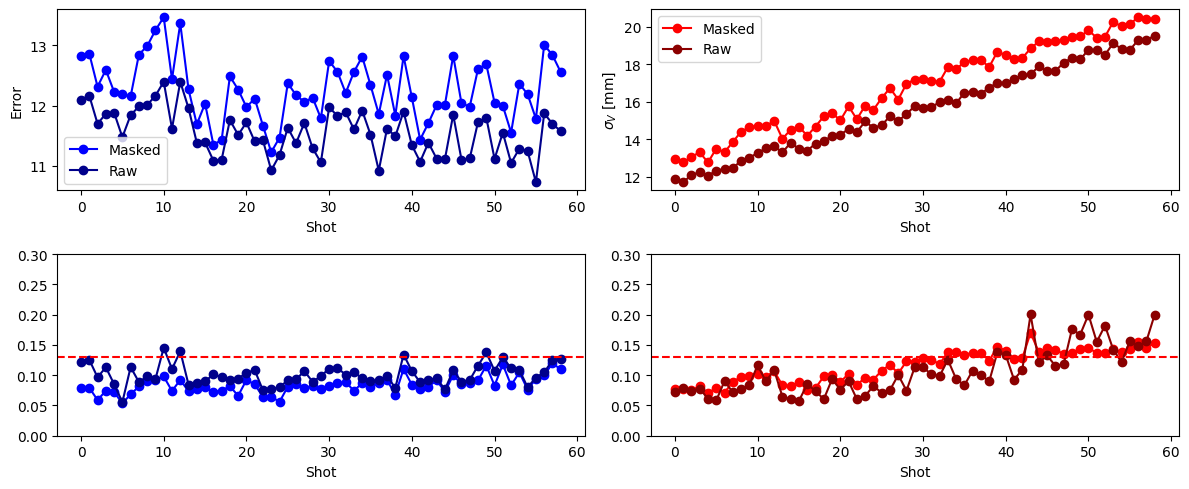

In [30]:
fig, ax = plt.subplots(2,2, figsize=(12,5), tight_layout=True)
ax[0,0].plot(sigH_list, c="b", marker="o", label="Masked")
ax[0,1].plot(sigV_list, c="r", marker="o", label="Masked")

ax[0,0].plot(sigH_list_ctrl, c="darkblue", marker="o", label="Raw")
ax[0,1].plot(sigV_list_ctrl, c="darkred", marker="o", label="Raw")

ax[0,0].set_xlabel("Shot")
ax[0,0].set_ylabel(r"$\sigma_{H}$ [mm]")
ax[0,1].set_xlabel("Shot")
ax[0,1].set_ylabel(r"$\sigma_{V}$ [mm]")

ax[0,0].legend()
ax[0,1].legend()

# Error
ax[1,0].plot(sigH_err_list, c="b", marker="o", label="Masked")
ax[1,1].plot(sigV_err_list, c="r", marker="o", label="Masked")

ax[1,0].plot(sigH_err_list_ctrl, c="darkblue", marker="o", label="Raw")
ax[1,1].plot(sigV_err_list_ctrl, c="darkred", marker="o", label="Raw")

ax[1,0].set_xlabel("Shot")
ax[0,0].set_ylabel("Error")
ax[1,1].set_xlabel("Shot")
# ax[0,1].set_ylabel(r"$\sigma_{V}$ [mm]")

ax[0,0].legend()
ax[0,1].legend()

ax[1,0].axhline(0.13, ls="--", c="r")
ax[1,1].axhline(0.13, ls="--", c="r")
ax[1,0].set_ylim(0,0.3)
ax[1,1].set_ylim(0,0.3)

In [ ]:
fig, ax = plt.subplots()
ax.plot(saturation_list, marker="o")
ax.set_ylabel("Saturation")

# Prepare the dataframe

/Users/eliottjohnson/git_repos/quad-scan-east/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eliottjohnson/git_repos/quad-scan-east/venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/8q/l42hhsl13fxd0py0_2dw6k900000gn/T/ipykernel_31441/322570387.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d = {'current_qfn01': current_qfn01, 'current_qdn02': current_qdn02, 'current_qfn03': current_qfn03, 'k_qfn01': float(df.k_qfn01.unique())*np.ones(len(df.k_qdn02.unique())), 'k_qdn02': df.k_qdn02.unique()*82/54, 'k_qfn03': float(df.k_qfn03.unique())*np.ones(len(df.k_qdn02.unique()))*82/54, 

(0.0, 0.3)

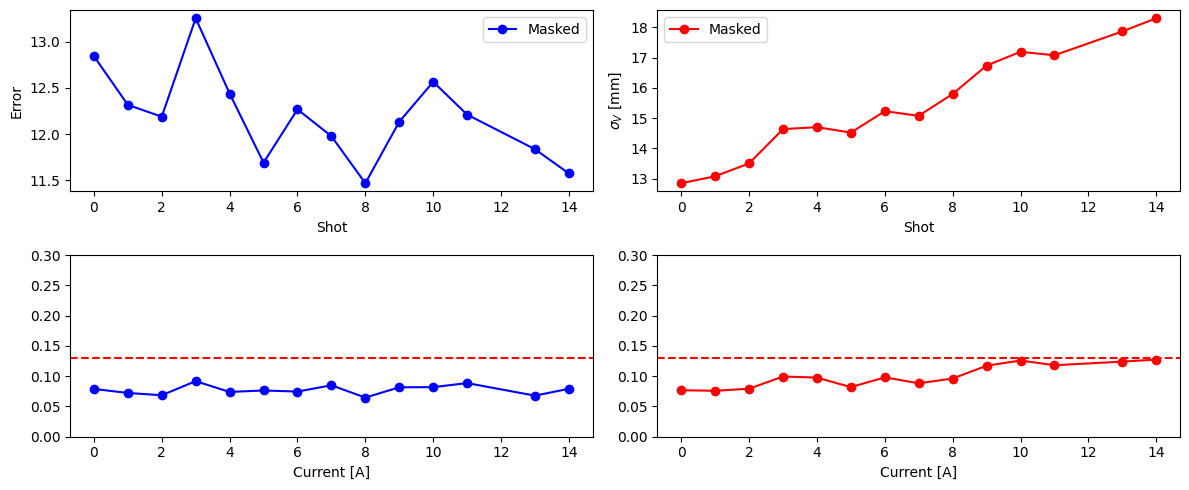

In [34]:
import pandas as pd

current_qfn01 = converter_dict["F61.QFN01/MEAS.PULSE#VALUE"]
current_qdn02 = converter_dict["F61.QDN02/MEAS.PULSE#VALUE"]
current_qfn03 = converter_dict["F61.QFN03/MEAS.PULSE#VALUE"]
sigH_list
sigV_list

k_qfn01 = []
for i in range(len(logical_k_dict['logical.F61.QFN01/K_FUNC_LIST#value'])):
    k = logical_k_dict['logical.F61.QFN01/K_FUNC_LIST#value'][i][0][1][0]
    k_qfn01.append(k)

k_qdn02 = []
for i in range(len(logical_k_dict['logical.F61.QDN02/K_FUNC_LIST#value'])):
    k = logical_k_dict['logical.F61.QDN02/K_FUNC_LIST#value'][i][0][1][0]
    k_qdn02.append(k)

k_qfn03 = []
for i in range(len(logical_k_dict['logical.F61.QFN03/K_FUNC_LIST#value'])):
    k = logical_k_dict['logical.F61.QFN03/K_FUNC_LIST#value'][i][0][1][0]
    k_qfn03.append(k)

d = {'current_qfn01': current_qfn01, 'current_qdn02': current_qdn02, 'current_qfn03': current_qfn03, 'k_qfn01': k_qfn01, 'k_qdn02': k_qdn02, 'k_qfn03': k_qfn03, 'sigH': sigH_list, 'sigV': sigV_list, 'sigH_err': sigH_err_list, 'sigV_err': sigV_err_list}
df = pd.DataFrame(data=d)
current_qfn01 = []
current_qdn02 = []
current_qfn03 = []
sigH = []
sigV = []
sigH_err = []
sigV_err = []
error_lim = 0.13
for k_qdn02 in df.k_qdn02.unique():

    sigH_med = np.median(df.loc[(df.k_qdn02 == k_qdn02) & (df.sigH_err < error_lim) & (df.sigV_err < error_lim)].sigH)
    sigH.append(sigH_med)
    sigV_med = np.median(df.loc[(df.k_qdn02 == k_qdn02) & (df.sigH_err < error_lim) & (df.sigV_err < error_lim)].sigV)
    sigV.append(sigV_med)

    sigH_err_med = np.median(df.loc[(df.k_qdn02 == k_qdn02) & (df.sigH_err < error_lim) & (df.sigV_err < error_lim)].sigH_err)
    sigH_err.append(sigH_err_med)
    sigV_err_med = np.median(df.loc[(df.k_qdn02 == k_qdn02) & (df.sigH_err < error_lim) & (df.sigV_err < error_lim)].sigV_err)
    sigV_err.append(sigV_err_med)

    current = np.median(df.loc[(df.k_qdn02 == k_qdn02) & (df.sigH_err < error_lim) & (df.sigV_err < error_lim)].current_qfn01)
    current_qfn01.append(current)
    current = np.median(df.loc[(df.k_qdn02 == k_qdn02) & (df.sigH_err < error_lim) & (df.sigV_err < error_lim)].current_qdn02)
    current_qdn02.append(current)
    current = np.median(df.loc[(df.k_qdn02 == k_qdn02) & (df.sigH_err < error_lim) & (df.sigV_err < error_lim)].current_qfn03)
    current_qfn03.append(current)

d = {'current_qfn01': current_qfn01, 'current_qdn02': current_qdn02, 'current_qfn03': current_qfn03, 'k_qfn01': float(df.k_qfn01.unique())*np.ones(len(df.k_qdn02.unique())), 'k_qdn02': df.k_qdn02.unique()*82/54, 'k_qfn03': float(df.k_qfn03.unique())*np.ones(len(df.k_qdn02.unique()))*82/54, 'sigH': sigH, 'sigV': sigV, 'sigH_err': sigH_err, 'sigV_err': sigV_err}
df = pd.DataFrame(data=d)
df.dropna(inplace=True)
fig, ax = plt.subplots(2,2, figsize=(12,5), tight_layout=True)
ax[0,0].plot(df.sigH, c="b", marker="o", label="Masked")
ax[0,1].plot(df.sigV, c="r", marker="o", label="Masked")

ax[0,0].set_xlabel("Shot")
ax[0,0].set_ylabel(r"$\sigma_{H}$ [mm]")
ax[0,1].set_xlabel("Shot")
ax[0,1].set_ylabel(r"$\sigma_{V}$ [mm]")

ax[0,0].legend()
ax[0,1].legend()

# Error
ax[1,0].plot(df.sigH_err, c="b", marker="o", label="Masked")
ax[1,1].plot(df.sigV_err, c="r", marker="o", label="Masked")

ax[1,0].set_xlabel("Current [A]")
ax[0,0].set_ylabel("Error")
ax[1,1].set_xlabel("Current [A]")
# ax[0,1].set_ylabel(r"$\sigma_{V}$ [mm]")

ax[0,0].legend()
ax[0,1].legend()

ax[1,0].axhline(0.13, ls="--", c="r")
ax[1,1].axhline(0.13, ls="--", c="r")
ax[1,0].set_ylim(0,0.3)
ax[1,1].set_ylim(0,0.3)

# Verify if the K's are correct for protons

In [35]:
# convert the current of the quadrupole to k, these should be scaled up by 82/54 to get the proton k (except for the first quadrupole)

from madxtools import transfer_function

i = 10

print(df.current_qfn01[i])
print(df.k_qfn01[i])
print(transfer_function.k1(df.current_qfn01[i], 'Q74L', 10.706*3.33564))
print("")

print(df.current_qdn02[i])
print(df.k_qdn02[i])
print(transfer_function.k1(df.current_qdn02[i], 'Q120C', 10.706*3.33564))
print("")

print(df.current_qfn03[i])
print(df.k_qfn03[i])
print(transfer_function.k1(df.current_qfn03[i], 'QFL', 10.706*3.33564))


# Conclusion: there is no need to convert the logical k, in the script I had already scale down by 54/82 (clever me!)

269.0495300292969
0.47969
0.4796917918954574

71.16029357910156
-0.10368444444444443
0.0682797668914756

73.25657653808594
0.13399407407407407
0.08824191121381937


# Save to pickle

In [36]:
with open("df/"+filename+"_df.pickle", 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
df

current_qfn01  current_qdn02  current_qfn03  k_qfn01   k_qdn02   k_qfn03  \
0      269.047897      89.102169      73.258560  0.47969 -0.130000  0.133994   
1      269.050293      87.312119      73.256943  0.47969 -0.127373  0.133994   
2      269.049133      85.508347      73.257233  0.47969 -0.124731  0.133994   
3      269.047302      83.719101      73.257950  0.47969 -0.122104  0.133994   
4      269.048981      81.926407      73.256447  0.47969 -0.119477  0.133994   
5      269.049500      80.125694      73.255920  0.47969 -0.116835  0.133994   
6      269.048767      78.335526      73.257294  0.47969 -0.114208  0.133994   
7      269.050842      76.545914      73.256447  0.47969 -0.111581  0.133994   
8      269.048340      74.754593      73.255707  0.47969 -0.108954  0.133994   
9      269.048096      72.953835      73.256470  0.47969 -0.106311  0.133994   
10     269.049530      71.160294      73.256577  0.47969 -0.103684  0.133994   
11     269.054932      69.372238      73.256447  0.47969 -0.101057  0.133994   
13     269.049438      65.780403      73.256927  0.47969 -0.095788  0.133994   
14     269.044907      63.986307      73.254768  0.47969 -0.093161  0.133994   

         sigH       sigV  sigH_err  sigV_err  
0   12.843832  12.844448  0.079008  0.076907  
1   12.316056  13.075051  0.072320  0.075921  
2   12.188196  13.499980  0.068590  0.079360  
3   13.253404  14.633169  0.091821  0.099496  
4   12.438966  14.698401  0.074027  0.097752  
5   11.690747  14.517984  0.076448  0.081978  
6   12.267454  15.226578  0.074646  0.098141  
7   11.976951  15.073010  0.085044  0.088349  
8   11.468385  15.796326  0.064687  0.096184  
9   12.133589  16.734748  0.081727  0.117371  
10  12.565341  17.189753  0.081924  0.125984  
11  12.210687  17.074177  0.088680  0.118155  
13  11.836325  17.863383  0.067891  0.124172  
14  11.573765  18.298747  0.079284  0.127508

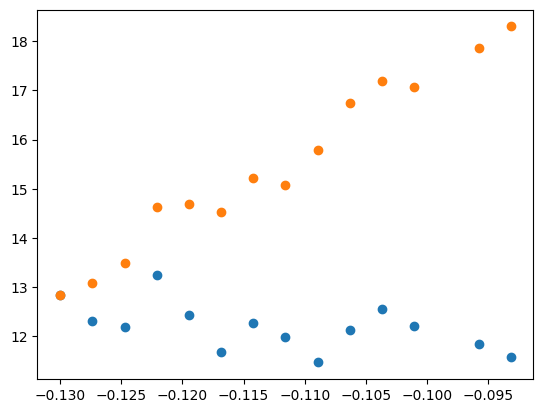

In [38]:
fig, ax = plt.subplots()

ax.scatter(df.k_qdn02, df.sigH)
ax.scatter(df.k_qdn02, df.sigV)

p = 578.1399136402882


(0.0, 0.3)

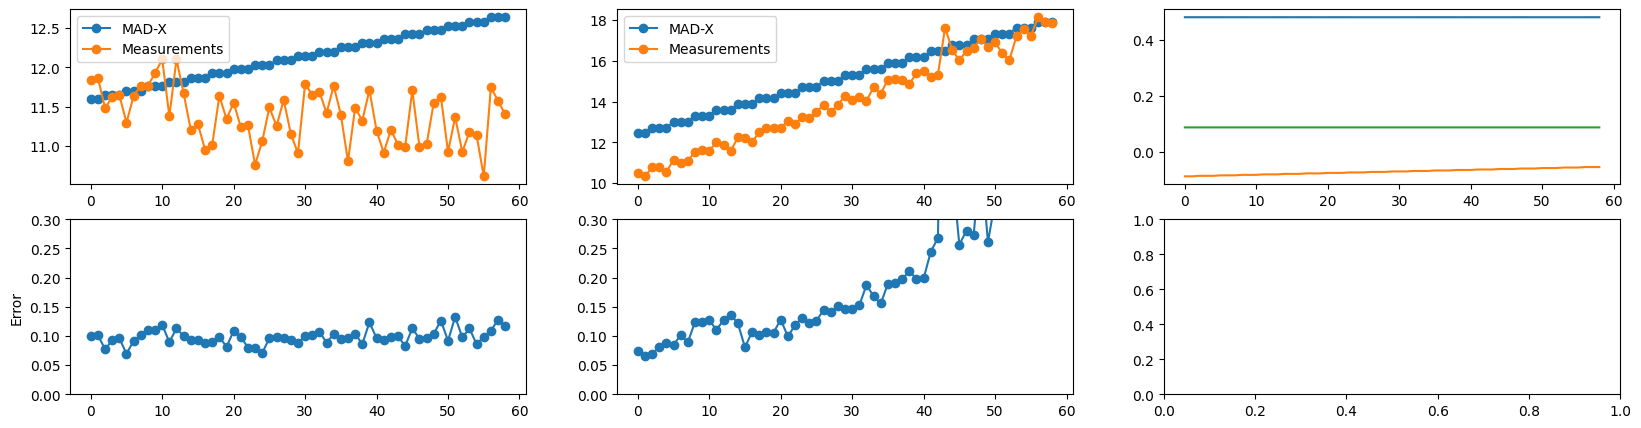

In [39]:
def beam_size(beta, dispersion, eps, dpp, n):
    """
    Simple calculation of beam size
    """
    beam = np.sqrt(eps*beta + (dpp*dispersion)**2)
    return beam*n
from cpymad.madx import Madx
import requests

betx0 = 142
bety0 = 5.2
alfx0 = -37
alfy0 = 0.25

dx0 = 0.13
dy0 = 0.0
dpx0 = 0.02
dpy0 = 0

exn = 7.6e-6
eyn = 3.5e-6
sige = 6.79e-4

                
E_cin_per_nucleon = 2
# Ion properties
A = 208.0
Z = 82.0
N = 126.0
charge = 54.0
m_proton_GeV = 0.93828
m_neutron_GeV = 0.93957
m_electron_GeV = 0.000511
m_u_GeV = 0.9315
mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)
print(f"p = {p}")

gamma = p/charge/0.938
beta = np.sqrt(1-gamma**(-2))

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)



with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.ele").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.str").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.seq").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.dbx").text) 
madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx.use(sequence="f61d")

fig, ax = plt.subplots(2,3, figsize=(20, 5))

btv="f61.btv010"

madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx.use(sequence="f61d")



H_sigma_madx_list = []
V_sigma_madx_list = []

H_sigma_meas_list = []
V_sigma_meas_list = []

H_sigma_meas_err_list = []
V_sigma_meas_err_list = []

k_qfn01_list = []
k_qdn02_list = []
k_qfn03_list = []

for shot_number in range(len(converter_dict['F61.QFN01/MEAS.PULSE#VALUE'])):

    try:
        k_qfn01 = transfer_function.k1(converter_dict['F61.QFN01/MEAS.PULSE#VALUE'][shot_number], 'Q74L', p/charge*3.33564)
        k_qdn02 = -transfer_function.k1(converter_dict['F61.QDN02/MEAS.PULSE#VALUE'][shot_number], 'Q120C', p/charge*3.33564)
        k_qfn03 = transfer_function.k1(converter_dict['F61.QFN03/MEAS.PULSE#VALUE'][shot_number], 'QFL', p/charge*3.33564)

        k_qfn01_list.append(k_qfn01)
        k_qdn02_list.append(k_qdn02)
        k_qfn03_list.append(k_qfn03)

        madx.input("kQFN1 = "+str(k_qfn01)+";")
        madx.input("kQDN2 = "+str(k_qdn02)+";")
        madx.input("kQFN3 = "+str(k_qfn03)+";")

        twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
        # *[ ] add air scattering

        H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
        V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000

        H_sigma_madx_list.append(H_sigma_madx)
        V_sigma_madx_list.append(V_sigma_madx)


        #Measurement
        acq = 3

        # Horizontal
        projPositionSet1 = btv_dict['F61D.BTV010/Acquisition'][shot_number]["projPositionSet1"][acq]
        projDataSet1 = btv_dict['F61D.BTV010/Acquisition'][shot_number]["projDataSet1"][acq]
        x_lim = [-50, 50]
        projPositionSet1_masked = projPositionSet1[(x_lim[0] <= projPositionSet1) & (projPositionSet1 <= x_lim[1])]
        projDataSet1_masked = projDataSet1[(x_lim[0] <= projPositionSet1) & (projPositionSet1 <= x_lim[1])]
        popt, pcov = do_gaussian_fit(projPositionSet1_masked, projDataSet1_masked)
        H_sigma_meas_list.append(popt[3])

        perr = np.sqrt(np.diag(pcov))
        H_sigma_meas_err_list.append(perr[3])

        # Vertical
        projPositionSet2 = btv_dict['F61D.BTV010/Acquisition'][shot_number]["projPositionSet2"][acq]
        projDataSet2 = btv_dict['F61D.BTV010/Acquisition'][shot_number]["projDataSet2"][acq]
        x_lim = [-20, 30]
        projPositionSet2_masked = projPositionSet2[(x_lim[0] <= projPositionSet2) & (projPositionSet2 <= x_lim[1])]
        projDataSet2_masked = projDataSet2[(x_lim[0] <= projPositionSet2) & (projPositionSet2 <= x_lim[1])]
        popt, pcov = do_gaussian_fit(projPositionSet2_masked, projDataSet2_masked)
        V_sigma_meas_list.append(np.abs(popt[3]))

        perr = np.sqrt(np.diag(pcov))
        V_sigma_meas_err_list.append(perr[3])

    except:
        pass



ax[0,0].plot(H_sigma_madx_list, marker="o", label="MAD-X")
ax[0,0].plot(H_sigma_meas_list, marker="o", label="Measurements")

ax[0,1].plot(V_sigma_madx_list, marker="o", label="MAD-X")
ax[0,1].plot(V_sigma_meas_list, marker="o", label="Measurements")

ax[0,0].legend()
ax[0,1].legend()

ax[0,2].plot(k_qfn01_list)
ax[0,2].plot(k_qdn02_list)
ax[0,2].plot(k_qfn03_list)

# Error
ax[1,0].plot(H_sigma_meas_err_list, marker="o", label="Measurements")
ax[1,1].plot(V_sigma_meas_err_list, marker="o", label="Measurements")
ax[1,0].set_ylabel("Error")


ax[1,0].set_ylim(0,0.3)
ax[1,1].set_ylim(0,0.3)